# <font color=blue size=5>Coletando tweets com a API v2</font>
***

#Instalando bibliotecas
Para esta coleta vamos utilizar as bibliotecas Tweepy e Pandas.<br>
*   Documentação Tweepy : https://docs.tweepy.org/en/stable/
*   Documentação Pandas: https://pandas.pydata.org/docs/index.html



In [ ]:
!pip install tweepy 
!pip install pandas

#Importanto as bibliotecas

In [2]:
import tweepy as tw
import pandas as pd

#Verificando as versões
É importante verificar a versão utilizar pois é possíveil que ocorra erros ao usar algumas funcionalidades. No meu caso foi necessário fazer um update do tweepy, pois estava ocorrendo um erro na classe Cliente que utilizaremos logo em seguida.

In [ ]:
!pip install tweepy==4.5.0 --upgrade #Necessário somente se ocorrer erro

In [3]:
print(f'Versão do tweepy: {tw.__version__}')
print(f'Versão do pandas: {pd.__version__}')

Versão do tweepy: 4.5.0
Versão do pandas: 1.3.5


#Utilizando as chaves de acesso
Na API V1 é necessário fazer a autenticação do usuário utilizando as chaves de acesso para que ocorra a conexão com o servidor do Twitter. E na API 2.0 não é diferente. Como se tratam de dados sensíveis, uma das maneiras de que podemos utilizar as chaves e manter a privacidade é abrindo um arquivo .txt utilizando a função 'open()'. Nesse arquivo estão contidas todas as chaves e o Python fara a leitura desses dados, sem expô-los. 

In [80]:
with open('twitter-chaves.txt', 'r') as tchaves:
  consumer_key = tchaves.readline().strip('\n')
  consumer_secret_key = tchaves.readline().strip('\n')
  bearer_token = tchaves.readline().strip('\n')
  access_token = tchaves.readline().strip('\n')
  access_token_secret = tchaves.readline().strip('\n')

Na versão da API V2 a classe 'tweepy.Client' funciona de maneira semelhante a 'tweepy.API' da API 1.0 e por aquela fazemos a autenticação atribuindo a variável 'client'.

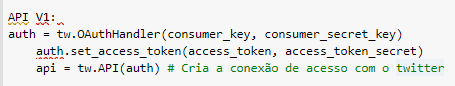

API V2:

In [81]:
client = tw.Client(bearer_token= bearer_token, consumer_key = consumer_key, consumer_secret= consumer_secret_key, access_token= access_token, access_token_secret = access_token_secret,wait_on_rate_limit=True)

#Coletando tweets utilizando uma query
Agora que temos a autenticação estabelecida, podemos iniciar a coleta de dados. O método que vamos utilizar aqui é o 'client.search_recent_tweets' que pesquisa pelo termo desejado com uma coleta máxima de 100 tweets por vez. O termo utilizado foi "#Eleição".
Para outros métodos, como 'Client.get_users_following' que coleta os perfils que um determinado perfil segue, é recomendável procurar na documentação o método desejável:
https://docs.tweepy.org/en/stable/

In [83]:
response = client.search_recent_tweets(query = "#Eleição -is:retweet" ,tweet_fields = ['created_at'], expansions = ['author_id'],
                                       user_fields = ['location'], max_results = 100)
# utizamos -is:retweet para que a nossa coleta nao retorne retweets

Por predefinição as informações dos tweets coletados contém o id da postagem e o campo de texto. Para adquirir as outras informações que queremos é necessário especificar por meio de 'fields' ou pelo argumento 'expansions'. Nesse exemplo vamos adicioar a data de criação da postagem ('tweet_fields = ['created_at']), localização do usuário (user_fields = ['location']), o id do usuário ['author_id'] com um resultado de 100 tweets por pesquisa ('max_results = 100').
A coleta pode ser personalizada de inúmeras formas e para mais informações sobre os 'fields' segue o link:
https://developer.twitter.com/en/docs/twitter-api/fields

In [84]:
response

Response(data=[<Tweet id=1575535277984124928 text=#eleicao #pec32 #Lula #bozo #Ciro #Gremio #Internacional #brasileirao https://t.co/RA6YKJijE4>, <Tweet id=1575534679763165185 text=👏🚌 São Leopoldo terá passe livre no transporte público no domingo de eleição

Veja a matéria completa:
https://t.co/CGJlg5rlog

#prefasaoleo #votação #eleição #passelivre #euamosaoleo #construindoumacidademelhor https://t.co/QIFT0EoZgD>, <Tweet id=1575533285371162625 text=#Eleição Em 100% das enquetes que vi aqui no Twitter, sendo a maioria criada por perfis de esquerda, Bolsonaro vence em TODAS. Quero testar aqui lançando essa enquete. Não tenho seguidores para influenciar nos resultados, vai ser baseado no seu RT. 

VOTE NA ENQUETE PRESIDENCIAL:>, <Tweet id=1575532859280035840 text=Delegados da PF denunciam Moraes por abuso de autoridade
https://t.co/qEdqN3GeWP

Delegados aposentados da Polícia Federal (PF) enviaram ao procurador-geral da república, Augusto Aras, uma notícia-crime em que pedem a abertura d

#Estruturando os dados coletados

Para entendermos o próximo passo, devemos analisar a estruturação dos dados que obtivemos como resposta.
Exemplo:

In [ ]:
  # "data": [
  #   {
  #     "id": "1263150595717730305",
  #     "author_id": "2244994945",
  #     "text": "Do you 👀our new Tweet settings?\n\nWe want to know how and why you’d use a feature like this in the API. Get the details and let us know what you think👇\nhttps://t.co/RtMhhfAcIB https://t.co/8wxeZ9fJER",
  #     "public_metrics": {
  #       "retweet_count": 12,
  #       "reply_count": 13,
  #       "like_count": 51,
  #       "quote_count": 7
  #     }
  #   }
  # ],
  # "includes": {
  #   "users": [
  #     {
  #       "id": "2244994945",
  #       "username": "TwitterDev",
  #       "description": "The voice of the #TwitterDev team and your official source for updates, news, and events, related to the #TwitterAPI.",
  #       "name": "Twitter Dev"
  #     }
  #   ]
  }


Como podemos observar "author_id" e "text" estão contidos em 'data' e todos os outros campos estão contidos em 'includes'. Para cada propriedade criamos uma lista para serem preenchidas com um laço. E para os campos de usuários que estao dentro de 'includes', criaremos um dicionário.

In [66]:
localizacao =[]
textos = []
creat_at = []
user_id = []

In [68]:
users = {u['id'] : u for u in response.includes['users']}
#Por response.includes['users'] temos acesso aos dados do usuário como vemos na estrutura dos dados de response:
  # "includes": {
  #   "users": [
  #     {
  #       "id": "2244994945",
  #       "username": "TwitterDev",
# Utilizando list cromprehension vamos preencher um dicionário onde 'u' é cada informação do usuário e tendo como chave do dicionário o seu id.

In [69]:
users

{1241018077745221635: <User id=1241018077745221635 name=Portal O Poder username=_portalopoder>,
 1123189197693706240: <User id=1123189197693706240 name=Biel Divulgações username=BielDivulgaes1>,
 1002258711296004097: <User id=1002258711296004097 name=.... username=Claracosta220>,
 1575323946240679937: <User id=1575323946240679937 name=Indecisos 1️⃣3️⃣ 🤖 username=indecisos2022>,
 1249342625620144131: <User id=1249342625620144131 name=Rose username=Rose22537013>,
 253982124: <User id=253982124 name=ElisetePenaOliveira username=ElisetePena>,
 26573303: <User id=26573303 name=Rádio BandNews FM username=radiobandnewsfm>,
 87829453: <User id=87829453 name=João Sarti username=joaosarti>,
 2370671718: <User id=2370671718 name=Victor Lucas username=V1torlucas00>,
 961781986003177478: <User id=961781986003177478 name=Gabriel Tussini username=gabrieltussini>,
 1506270408567316495: <User id=1506270408567316495 name=Datapedia.info username=datapedia_info>,
 1548040472009928705: <User id=15480404720

In [70]:
for tweet in response.data:
# Com o dicionário com as informações dos usuários criado, podemos mapear essas informações utizando
# o id do usuário que também esta presente na variável  que criamos no laço 'tweet'.
  if users[tweet.author_id]:
    user = users[tweet.author_id]
    localizacao.append(user.location)
# As outras informações estão contidas na variável tweet  
  user_id.append(tweet.author_id)
  textos.append(tweet.text)
  creat_at.append(tweet.created_at)

#Criando um Data Frame

Agora é só criar um data frame utilizando as listas preenchidas com as informações.

In [71]:
df =pd.DataFrame({'Textos' : textos, 'user_id': user_id, 'Criado em': creat_at, "Localidade" : localizacao})

In [72]:
df

,Textos,user_id,Criado em,Localidade
0,"No momento do incidente, a câmera estava direc...",1241018077745221635,2022-09-29 16:03:04+00:00,"Manaus, Brasil"
1,"💬 Conforme vídeo divulgado nas redes sociais, ...",1241018077745221635,2022-09-29 15:54:33+00:00,"Manaus, Brasil"
2,ZÉ FELIPE CANCELA SHOWS POR FALTA DE LOTAÇÃO? ...,1123189197693706240,2022-09-29 15:43:42+00:00,None
3,Vamos deixar de ser o País do futebol para ser...,1002258711296004097,2022-09-29 15:07:09+00:00,"Nova Iorque, USA"
4,RT @em_com: DEBATE DA GLOBO\nAlexandre Kalil (...,1575323946240679937,2022-09-29 15:00:34+00:00,Brazil
...,...,...,...,...
95,RT @em_com: DEBATE DA GLOBO\nAlexandre Kalil (...,1521688957720965120,2022-09-28 16:25:19+00:00,JF/MG
96,#evangelho #política #eleição #BolsonaroReelei...,358737104,2022-09-28 16:16:14+00:00,Brazil
97,Acesse o site https://t.co/xN9lqBDsjj e escolh...,2911411251,2022-09-28 16:03:29+00:00,None
98,😊COPO PARA MILK SHAKE 300 ML CONJ. 2 UNID.😊\n\...,910941576129601536,2022-09-28 15:58:27+00:00,Av. Winston Churchill 539


#Busca com resposta que contenha mais que 100 tweets.
Assim como na API V1 também é possivel fazer uma coleta com um retorno maior que 100 tweets em uma única busca. Client.paginator na API V2 faz a mesma função que o api.Cursor na API V1.
Ao utilizar esse método nao é possivel utilizar 'user_fields', pois como vimos acima, essa parte dos dados ficam em 'includes' e essa porção não é retornada ao usar flatten(). Por isso as opções de propriedades de coleta de dados são menores.

In [139]:
tweets = tw.Paginator(client.search_recent_tweets, query = "Eleição -is:retweet", tweet_fields = ['author_id', 'created_at'],
                          place_fields=['place_type', 'geo'],
                         max_results = 100).flatten(limit = 300)

In [140]:
for i in tweets:
  print(i.text)


@_Mordacious_ Fazer igual ao Lula, não serei preso por eleição kkk
@Metropoles Como assim, a eleição ja aconteceu? 
Não estou sabendo que Bolsonaro perdeu eleição!
Para questionar alhuna coisa.
Parece que o sistema esta bugando.
No último sábado, o @CartaDeBelem promoveu um debate, em PoA (RS)  sobre os impactos já sentidos pelas comunidades em seus territórios com o avanço da entrega da gestão de áreas protegidas à iniciativa privada.

Quer saber mais? Acesse no link: https://t.co/JLHhEgYTUb https://t.co/r5ysyG36SG
@joaovrsouza @LuizPersechini Então para senador já avaliou as pesquisas e definiu voto útil. Pois eu estava falando de eleição para o senado. Esse ano é uma vaga, e eleger o menos pior é extremamente importante. Não tem outra chance. É muita energia em campanha presidencial, tanta que dá curto circuito.
@aosfatos @TSEjusbr Eleição sombria.
Sábado final da Sulamericana e domingo eleição. 

Minha depressão está na reta, nesse final de semana.
@folha Mal sabe a moça que a maio